<p style="font-size:32px; font-weight: bolder; text-align: center"> Constant-pressure (PI)MD </p>
<p style="text-align: center"><i> authored by: <a href="mailto:michele.ceriotti@gmail.com"> Michele Ceriotti </a></i></p>

This notebook provides a demonstration of how to perform constant-pressure simulations using [i-PI](https://ipi-code.org), and serves also as a brief re-cap of how to use the code. You can run simulations through the notebook, or follow the instructions on the command-line, coming back to the notebook for visualizing the results.  

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import ase, ase.io
import chemiscope
import pimdmooc
import warnings
pimdmooc.add_ipi_paths()

# Constant-pressure simulations

Atomistic simulations often use a _supercell_ approach to describe bulk systems: atoms are described as if they were part of an infinite system, that repeats periodically according to the lattice vectors of a very large unit cell. This is also suitable to describe disordered systems and liquids (provided this supercell is sufficiently large), but has a limitation in that it corresponds to constant volume (_NVT_) thermodynamic boundary conditions.

It is often useful to perform simulations at constant pressure (_NpT_) conditions, which requires a change in the equations of motion, that allows for a change in the size (and possibly shape) of the supercell. The core ideas on how to achieve this are described in a foundational paper ([H. C. Andersen, JCP 72(4), 2384–2393 (1980)](https://doi.org/10.1063/1.439486)), that introduced both thermostatting and barostatting to molecular simulations.

<div align="center">
  <img style='width:80%' src="figures/npt-ensemble.png" alt="A schematic representation of a gas interacting with a piston that enables volume fluctuations"/>
</div>


To do this, one needs to make the cell volume $V$ a dynamical variable, with an associated fictitious mass $\mu$ and momentum $\alpha$. Different types of equations of motion, derived in terms of an extended Lagrangian, can be obtained that guarantee that in the ergodic limit the system samples the constant-temperature/constant-pressure distribution $P(\mathbf{q},\mathbf{p})\propto \exp(-\beta(E+pV))$. 

An example of these equations is

$$
\begin{split}
\dot{q}=&\frac{p}{m}+\alpha q/\mu\\
\dot{p}=&-\partial U/\partial q-\alpha p/\mu\\
\dot{V}=&3V\alpha/\mu\\
\dot{\alpha}=&3\left[V\left(P_\mathrm{int}-P_\mathrm{ext}\right)+2k_{B}T\right]\\
P_\mathrm{int}=&\frac{2K}{3V}-\frac{dU}{dV}\\
\end{split}
$$

which introduces the internal pressure estimator $P_\mathrm{int}$, depending on the kinetic energy $K$ and on the _total_ derivative of the potential with respect to the cell volume $dU/dV$.

<a id="setting-up"> </a>

# Setting up a NpT calculation

To keep things simple, we will use the para-hydrogen potential [I. Silvera and V. Goldman, J. Chem. Phys., 69, 4209 (1978)](https://doi.org/10.1063/1.437103) implemented in the FORTRAN driver distributed with i-PI. We will perform simulations at 25 K, where quantum effects for para-hydrogen are very pronounced, but we will start performing a classical MD simulation. 

## Input files

Inputs to run molecular dynamics in the constant-pressure ensemble can be found in the `01-constant-pressure` folder. You will find a `para-h2.pdb` file that contains the starting positions of the atoms, and `npt-md.xml`, the actual i-PI input. Let's have a look at them.

The first section of the file defines the logging level (`verbosity='medium'`), the content of output files (i-PI does not output unless required) and the total number of simulation steps that should be run

In [12]:
!sed -n '1,7p' 01-constant_pressure/npt-md.xml

<simulation verbosity='medium'>
  <output prefix='ph2-npt-md'>
    <properties filename='md' stride='10'> [step, time{picosecond}, conserved{electronvolt}, temperature{kelvin}, potential{electronvolt}, kinetic_md{electronvolt}, pressure_md{megapascal}, volume{angstrom3}] </properties>
    <trajectory filename='pos' stride='100' format='pdb' cell_units='angstrom'> positions{angstrom} </trajectory>
    <checkpoint filename='checkpoint' stride='1000' overwrite='True'/>
  </output>
  <total_steps> 5000 </total_steps>


Next comes the definition of the forcefield. In this case (the most common in i-PI) we use a socket to communicate with an external driver. The `<address>` tag specifies the socket name (in this case a UNIX domain socket, it would be the IP or hostname in the case of a TCP/IP socket), while the `name` attribute specifies how this forcefield will be referred to when defining the actual physical interactions. 

In [13]:
!sed -n '8,10p' 01-constant_pressure/npt-md.xml

  <ffsocket mode='unix' name='ph2-ff'>
    <address> ph2-driver</address>
  </ffsocket>


The `<system>` tag defines everything that is system-related. `<initialize>` specifies where to fetch the initial atomic positions and cell size, while `<velocities>` instructs i-PI on how to initialize the particle momenta. Note that we have to specify that the temperature is given in kelvin, as i-PI assumes otherwise that it is provided in atomic units.

`<forces>` specifies how to construct interactions. In this case, we simply fetch them from the single forcefield we have defined, but we shall see how more complicated setups can be realized. 
Finally, `<ensemble>` defines the thermodynamic boundary conditions: in this case, temperature and pressure. 

In [14]:
!sed -n '11,22p' 01-constant_pressure/npt-md.xml

  <system>
    <initialize nbeads='1'>
      <file mode='pdb'> para-h2.pdb </file>
      <velocities mode='thermal' units='kelvin'> 25 </velocities>
    </initialize>
    <forces>
      <force forcefield='ph2-ff'/>
    </forces>
    <ensemble>
      <temperature units='kelvin'> 25 </temperature>
      <pressure units='megapascal'> 50 </pressure>
    </ensemble>


The way the position of the atoms should be evolved is specified in the `<motion>` section. In this case, we run molecular dynamics in the `npt` ensemble, which means we also have to specify a `<thermostat>` and a `<barostat>`. We use a Langevin piston barostat, which requires its own separate thermostat. We also specify `<timestep>`, and the time constants of all methods. 

In [15]:
!sed -n '23,40p' 01-constant_pressure/npt-md.xml

    <motion mode='dynamics'>
      <dynamics mode='npt'>
        <thermostat mode='pile_g'>
          <tau units='femtosecond'> 25 </tau>
        </thermostat>
        <barostat mode='isotropic'>
          <thermostat mode='langevin'>
            <tau units='femtosecond'> 50 </tau>
          </thermostat>
          <tau units='femtosecond'> 250 </tau>
        </barostat>
        <timestep units='femtosecond'> 1 </timestep>
      </dynamics>
    </motion>
  </system>
</simulation>


## Running simulations

We are going to launch i-PI from here, but you could do the same opening a terminal. Note that we launch i-PI, wait a couple of second for it to start up and open a socket, and then launch `i-pi-driver` to evaluate energy and forces. We put everything in background and detach the processes from the jupyter instance, so we can continue the execution. **DON'T RE-RUN THE CELL BEFORE THE CALCULATION HAS FINISHED** to avoid conflicts and file overwriting. 

In [16]:
%%bash --bg
cd 01-constant_pressure
PYTHONUNBUFFERED=1 i-pi npt-md.xml &> log.md &
sleep 5
i-pi-driver -u -a ph2-driver -m sg -o 15 -v &> log.driver

You can view the log from here, or move on to visualize the results

In [36]:
!tail -n 20 01-constant_pressure/log.md

 # Average timings at MD step    3600. t/step: 4.19789e-02
 # Average timings at MD step    3700. t/step: 3.78129e-02
 # Average timings at MD step    3800. t/step: 4.18019e-02
 # Average timings at MD step    3900. t/step: 3.90361e-02
 # Average timings at MD step    4000. t/step: 4.13204e-02
 # Average timings at MD step    4100. t/step: 3.91628e-02
 # Average timings at MD step    4200. t/step: 4.08930e-02
 # Average timings at MD step    4300. t/step: 4.73714e-02
 # Average timings at MD step    4400. t/step: 3.31782e-02
 # Average timings at MD step    4500. t/step: 3.92510e-02
 # Average timings at MD step    4600. t/step: 4.04831e-02
 # Average timings at MD step    4700. t/step: 3.95914e-02
 # Average timings at MD step    4800. t/step: 3.71083e-02
 # Average timings at MD step    4900. t/step: 5.42488e-02
SOFTEXIT CALLED FROM THREAD <_MainThread(MainThread, started 140680583317312)>  @ SIMULATION: Exiting cleanly.
 !W! Soft exit has been requested with message: ' @ SIMULATION:

## Visualizing and analyzing results

We use some utility functions to read the output of i-PI and visualize it. Note the fast equilibration of the cell volume, and how the pressure estimator converges to the target value. 

In [37]:
md_output = pimdmooc.read_ipi_output('01-constant_pressure/ph2-npt-md.md')

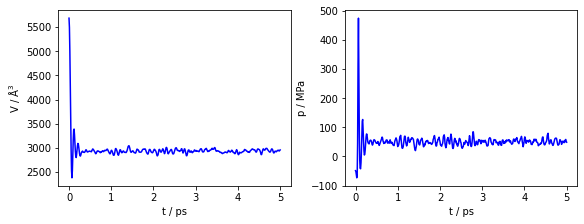

In [39]:
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(8,3))
ax[0].plot(md_output["time"], md_output["volume"], 'b-', label="V / Å$^3$")
ax[0].set_xlabel("t / ps")
ax[0].set_ylabel("V / Å$^3$")
ax[1].plot(md_output["time"], md_output["pressure_md"], 'b-', label="p / MPa")
ax[1].set_xlabel("t / ps")
ax[1].set_ylabel("p / MPa");

In [40]:
# loads structures, discarding unused atom properties
warnings.filterwarnings('ignore', '.*residuenumbers array.*')
frames = ase.io.read('01-constant_pressure/ph2-npt-md.pos_0.pdb', ":")
for f in frames:
    f.info = {}
    f.arrays = {'positions': f.positions,  'numbers': f.numbers}

We can also use `chemiscope` to visualize the trajectory. Notice the rapid equilibration of the supercell. 

In [41]:
chemiscope.show(frames=frames, 
                     properties={
                         "t" : { "values":  md_output["time"][::10], "units": "ps", "target":"structure"},
                         "U" : { "values":  md_output["potential"][::10], "units": "eV", "target":"structure"},
                         "V" : { "values":  md_output["volume"][::10], "units": r"Å", "target":"structure"}
                     },
                     settings = {
                         'structure': [{ 'keepOrientation': True, 
                                         'unitCell': True,
                                         'playbackDelay': 20}],
                        'map': {'x': {'max': 5,  'min': 0, 'property': 't', 'scale': 'linear'},
                                'y': {'max': 3500,  'min': 2800, 'property': 'V', 'scale': 'linear'},
                                 'color': {'property': 'U'}
                               }
                     })

ChemiscopeWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"keepOrientation": true, "unitCell…

# Constant-pressure path integrals

Systems such as para-hydrogen at cryogenic temperatures exhibit large quantum effects, which affect their thermodynamic properties, and in particular their equations of state. Performing _NpT_ simulation with quantum nuclei in i-PI is comparatively simple: the cell degrees of freedom are not quantized, and so in practice one only needs to change the estimator for $P_\mathrm{int}$ to be one based on the centoid-virial estimator, and to increase the number of beads in the simulation. 

From the implementation side, there are some subtleties: for an efficient implementation, only the centroid of the ring polymers should be coupled to the volume scaling: the equations of motion, including also a Langevin thermostat for the path integral replicas and one for the cell degrees of freedom (a "Langevin piston" thermostat) read

$$
\begin{split}
\dot{\tilde{\mathbf{p}}}^{(k)}_i = & \sqrt{\frac{2nm_i\gamma_k}{\beta}} \boldsymbol{\xi}^{(k)}_i 
-\gamma_k {\tilde{\mathbf{p}}}^{(k)}_i 
+ {\tilde{\mathbf{f}}^{(k)}_i }
- \tilde{\mathbf{p}}^{(k)}_i \delta_{k0}\, {\alpha}/{\mu}
- m_{i}\omega_k^2 \tilde{\mathbf{q}}^{(k)}_i \\
\dot {\tilde{\mathbf{q}}}^{(k)}_i =  & {\tilde{\mathbf{p}}^{(k)}_i }/{m_i} + \tilde{\mathbf{q}}^{(k)}_i  \delta_{k0} \, {\alpha}/{\mu} \\
\dot {V} = & 3 V \,{\alpha}/{\mu} \\
\dot{\alpha} = & \sqrt{\frac{2 n\mu \gamma_\alpha}{\beta}} \xi_\alpha - \gamma_\alpha \alpha 
   + 3 n \left[V \left(P_{\rm int}-P_{\rm ext}\right)+\frac{1}{\beta}\right].
\end{split}
$$

You can read more about the theory and the implementation on the paper that accompanied the first release of i-PI ([M. Ceriotti, J. More, and D. E. Manolopoulos, Comp. Phys. Comm. 185(3), 1019–1026 (2014)](https://doi.org/10.1016/j.cpc.2013.10.027)).

From a practical perspective, there is very little that needs to be changed in the input file. You can see in `npt-pimd.xml` that we only change the output properties to provide the centroid-virial kinetic energy and pressure estimators, and change `nbeads` to 4. 

In [23]:
!sed -n '2,6p' 01-constant_pressure/npt-pimd.xml
print("\n[....]\n")
!sed -n '12p' 01-constant_pressure/npt-pimd.xml

  <output prefix='ph2-npt-pimd'>
    <properties filename='md' stride='10'> [step, time{picosecond}, conserved{electronvolt}, temperature{kelvin}, potential{electronvolt}, kinetic_cv{electronvolt}, pressure_cv{megapascal}, volume{angstrom3}] </properties>
    <trajectory filename='pos' stride='100' format='pdb' cell_units='angstrom'> positions{angstrom} </trajectory>
    <checkpoint filename='checkpoint' stride='1000' overwrite='True'/>
  </output>

[....]

    <initialize nbeads='4'>


## Running PIMD simulations

Given that we use four replicas, we can run multiple drivers and exploit the trivial parallelism in the calculation of the potential.

In [26]:
%%bash --bg
cd 01-constant_pressure
PYTHONUNBUFFERED=1 i-pi npt-pimd.xml &> log.pimd &
sleep 5
for i in `seq 1 4`; do
   i-pi-driver -u -a ph2-driver-pi -m sg -o 15 -v &> log.driver.$i &
done
wait

You can view the log from here, or move on to visualize the results

In [46]:
!tail -n 20 01-constant_pressure/log.pimd

 # Average timings at MD step    3600. t/step: 4.53720e-02
 # Average timings at MD step    3700. t/step: 4.77827e-02
 # Average timings at MD step    3800. t/step: 4.64186e-02
 # Average timings at MD step    3900. t/step: 5.95865e-02
 # Average timings at MD step    4000. t/step: 5.08420e-02
 # Average timings at MD step    4100. t/step: 5.02388e-02
 # Average timings at MD step    4200. t/step: 4.84722e-02
 # Average timings at MD step    4300. t/step: 4.53573e-02
 # Average timings at MD step    4400. t/step: 4.54709e-02
 # Average timings at MD step    4500. t/step: 4.30920e-02
 # Average timings at MD step    4600. t/step: 4.43793e-02
 # Average timings at MD step    4700. t/step: 4.80124e-02
 # Average timings at MD step    4800. t/step: 4.85401e-02
 # Average timings at MD step    4900. t/step: 5.14690e-02
SOFTEXIT CALLED FROM THREAD <_MainThread(MainThread, started 140699804796736)>  @ SIMULATION: Exiting cleanly.
 !W! Soft exit has been requested with message: ' @ SIMULATION:

## Post-processing

Let's now load up the trajectory and compare it to the classical one

In [47]:
pimd_output = pimdmooc.read_ipi_output('01-constant_pressure/ph2-npt-pimd.md')

Pressure equilibrates rapidly to the target value of 50 MPa, but the equilibrium volume is much larger than that from the classical simulation, because of zero-point energy effects.

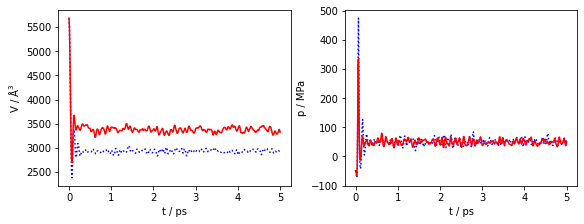

In [48]:
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(8,3))
ax[0].plot(md_output["time"], md_output["volume"], 'b:', label="MD")
ax[0].plot(pimd_output["time"], pimd_output["volume"], 'r-', label="PIMD")
ax[0].set_xlabel("t / ps")
ax[0].set_ylabel("V / Å$^3$")
ax[1].plot(md_output["time"], md_output["pressure_md"], 'b:', label="MD")
ax[1].plot(pimd_output["time"], pimd_output["pressure_cv"], 'r-', label="PIMD")
ax[1].set_xlabel("t / ps")
ax[1].set_ylabel("p / MPa");

Zero-point energy is also very apparent on the energetics: potential and kinetic energy in the quantum simulation are much larger, similar to what one would observe in a constant-volume simulation. 

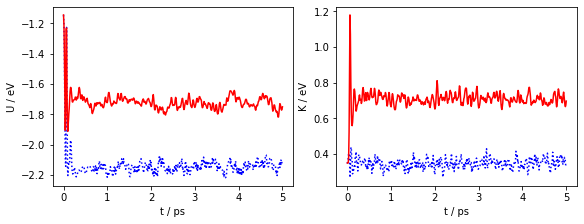

In [49]:
fig, ax = plt.subplots(1,2,constrained_layout=True, figsize=(8,3))
ax[0].plot(md_output["time"], md_output["potential"], 'b:', label="MD")
ax[0].plot(pimd_output["time"], pimd_output["potential"], 'r-', label="PIMD")
ax[0].set_xlabel("t / ps")
ax[0].set_ylabel("U / eV")
ax[1].plot(md_output["time"], md_output["kinetic_md"], 'b:', label="MD")
ax[1].plot(pimd_output["time"], pimd_output["kinetic_cv"], 'r-', label="PIMD")
ax[1].set_xlabel("t / ps")
ax[1].set_ylabel("K / eV");

We can also load and visualize the PIMD simulations, combining the different beads to show the spread of the ring-polymers. The supercell is identical in all replicas, consistently with the fact it is treated classically. 

In [50]:
# loads structures, discarding unused atom properties
warnings.filterwarnings('ignore', '.*residuenumbers array.*')
pi_frames = [ ase.io.read('01-constant_pressure/ph2-npt-pimd.pos_'+str(i)+'.pdb', ":") for i in range(4) ]
frames = []
for idx_f in range(len(pi_frames[0])):
    f = pi_frames[0][idx_f]
    for k in range(1,4):
        f += pi_frames[k][idx_f]
    f.info = {}
    f.arrays = {'positions': f.positions,  'numbers': f.numbers}
    frames.append(f)

In [51]:
chemiscope.show(frames=frames, 
                     properties={
                         "t" : { "values":  pimd_output["time"][::10], "units": "ps", "target":"structure"},
                         "U" : { "values":  pimd_output["potential"][::10], "units": "eV", "target":"structure"},
                         "V" : { "values":  pimd_output["volume"][::10], "units": r"Å", "target":"structure"}
                     },
                     settings = {
                         'structure': [{ 'bonds': False, 
                                         'keepOrientation': True, 
                                         'unitCell': True,
                                         'playbackDelay': 20}],
                        'map': {'x': {'max': 5,  'min': 0, 'property': 't', 'scale': 'linear'},
                                'y': {'max': 3500,  'min': 2800, 'property': 'V', 'scale': 'linear'},
                                 'color': {'property': 'U'}
                               }
                     })

ChemiscopeWidget(value='{"meta": {"name": " "}, "settings": {"structure": [{"bonds": false, "keepOrientation":…